## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
horizontal_wavelet_coronal_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/coronal/wavelet/horizontal'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0,
 3: 19544,
 4: 177766,
 5: 820632,
 6: 3670424,
 7: 15384514,
 8: 62976002,
 9: 254776200}

Running 12760 CDFs


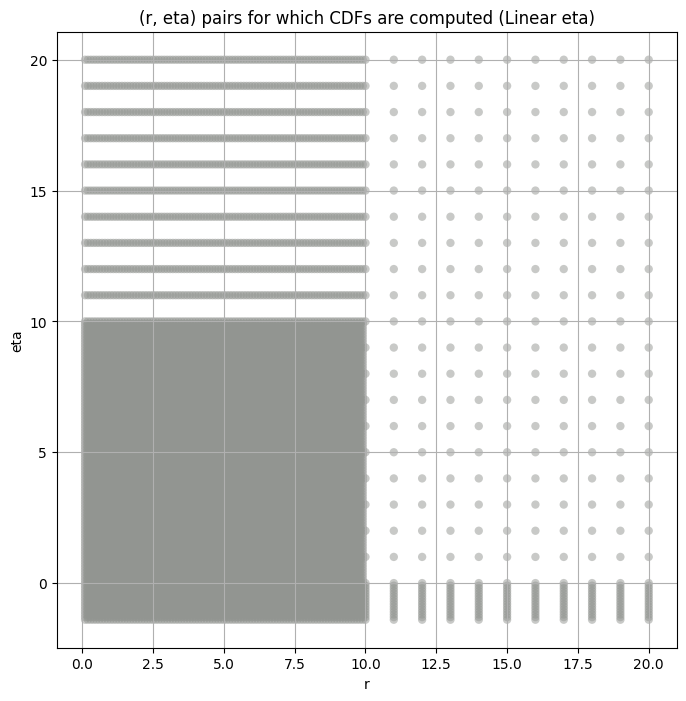

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:18<00:00, 5386.60it/s]


Layer 3


100%|██████████| 100000/100000 [00:49<00:00, 2013.85it/s]


Layer 4


100%|██████████| 100000/100000 [00:41<00:00, 2392.08it/s]


Layer 5


100%|██████████| 100000/100000 [00:42<00:00, 2335.12it/s]


Layer 6


100%|██████████| 100000/100000 [00:44<00:00, 2266.21it/s]


Layer 7


100%|██████████| 100000/100000 [00:42<00:00, 2341.80it/s]


Layer 8


100%|██████████| 100000/100000 [00:42<00:00, 2326.18it/s]


Layer 9


100%|██████████| 100000/100000 [00:43<00:00, 2299.92it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,170305.00000,164909.47000,175804.86000,-0.464481,-0.540597,-0.383066,19544.0
4,269349.47000,260584.97000,278149.56000,-0.415785,-0.529190,-0.262445,177766.0
5,89765.79000,85311.62000,94332.43000,1.816636,1.392810,2.345721,820632.0
6,27723.13700,25801.26000,29725.77000,5.616802,4.711250,6.687731,3670424.0
7,5939.07570,5490.06700,6403.12160,7.063244,6.073430,8.459994,15384514.0
8,762.61380,692.95807,839.26680,11.767686,8.738594,18.807537,62976002.0
9,72.97091,64.01033,83.24985,23.847502,14.821177,42.472622,254776200.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,170305.00000,170305.000000,167002.609375,164473.203125,162222.562500,160110.406250,156242.156250,152724.328125,149457.687500,146423.140625,143552.140625,135714.921875
4,269349.47000,269349.468750,267502.156250,266254.625000,265186.593750,264230.187500,262476.156250,260888.015625,259405.281250,258001.937500,256648.734375,252800.015625
5,89765.79000,89765.789062,88552.343750,87637.570312,86815.734375,86059.968750,84706.250000,83501.929688,82409.046875,81401.945312,80466.125000,77970.710938
6,27723.13700,27723.136719,27162.533203,26711.710938,26304.953125,25929.019531,25245.236328,24632.085938,24072.082031,23557.511719,23081.964844,21839.484375
7,5939.07570,5939.075684,5809.565430,5708.381836,5617.515625,5533.830078,5381.856445,5244.973633,5119.251953,5002.623535,4893.500488,4600.954102
8,762.61380,762.613770,732.881775,714.530029,699.353455,685.930908,662.387817,641.806030,623.298340,606.402527,590.797852,549.847168
9,72.97091,72.970909,68.017906,65.315224,63.206810,61.415382,58.408737,55.894657,53.712879,51.777607,50.035976,45.663059


####
Layer  2
####
Layer  3


100%|██████████| 12760/12760 [00:09<00:00, 1309.56it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.02137939222871399 170305.0


100%|██████████| 12760/12760 [00:10<00:00, 1252.59it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.023321938303791978 167002.61


100%|██████████| 12760/12760 [00:09<00:00, 1281.17it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.024882507661585618 164473.2


100%|██████████| 12760/12760 [00:11<00:00, 1132.81it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.026320765228824983 162222.56


100%|██████████| 12760/12760 [00:11<00:00, 1123.61it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.027669609635848413 160110.4


100%|██████████| 12760/12760 [00:10<00:00, 1263.41it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.0302228590918438 156242.16


100%|██████████| 12760/12760 [00:09<00:00, 1291.75it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.0326157999309587 152724.33


100%|██████████| 12760/12760 [00:09<00:00, 1303.33it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.03488211492260518 149457.69


100%|██████████| 12760/12760 [00:09<00:00, 1397.09it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.037064482322892695 146423.14


100%|██████████| 12760/12760 [00:08<00:00, 1457.24it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.03922585109760468 143552.14


100%|██████████| 12760/12760 [00:08<00:00, 1438.98it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.045552155311633785 135714.92
Number of samples: 19544, Without approximation : 19544.0


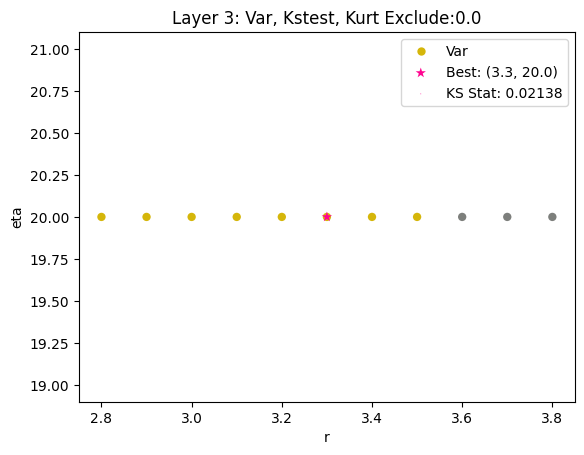

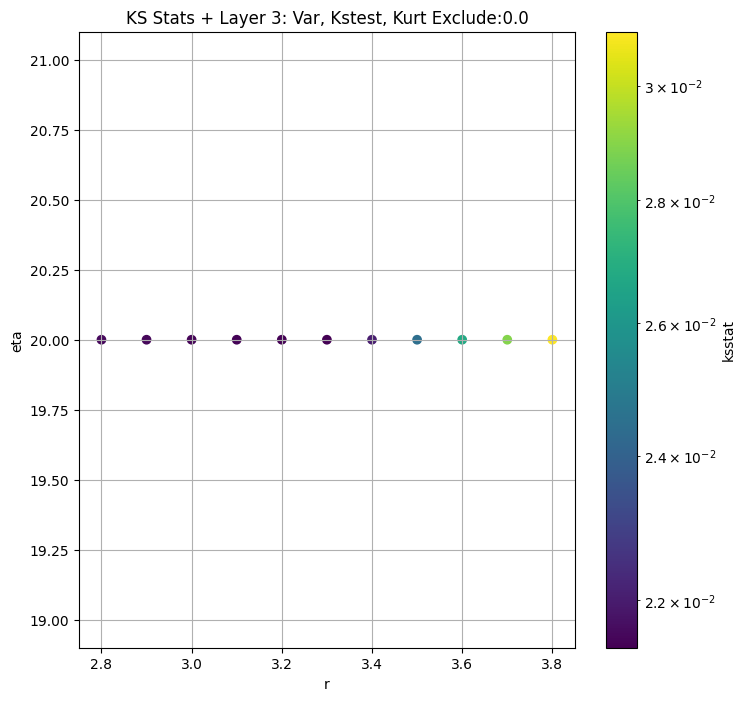

####
Layer  4


100%|██████████| 12760/12760 [00:46<00:00, 273.95it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.02401096317428736 269349.47


100%|██████████| 12760/12760 [00:49<00:00, 258.62it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.024804264230758155 267502.16


100%|██████████| 12760/12760 [00:48<00:00, 261.89it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.02534365744232711 266254.62


100%|██████████| 12760/12760 [00:44<00:00, 289.59it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.025807807751706935 265186.6


100%|██████████| 12760/12760 [00:46<00:00, 276.00it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.026225315315881903 264230.2


100%|██████████| 12760/12760 [00:47<00:00, 266.28it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.026995644249397655 262476.16


100%|██████████| 12760/12760 [00:48<00:00, 262.27it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.0276706099201538 260888.02


100%|██████████| 12760/12760 [00:47<00:00, 270.97it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.028297824978183117 259405.28


100%|██████████| 12760/12760 [00:44<00:00, 286.62it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.0289271525681552 258001.94


100%|██████████| 12760/12760 [00:44<00:00, 289.69it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.02953778721958844 256648.73


100%|██████████| 12760/12760 [00:45<00:00, 281.03it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.03129521311393435 252800.02
Number of samples: 100000, Without approximation : 177766.0


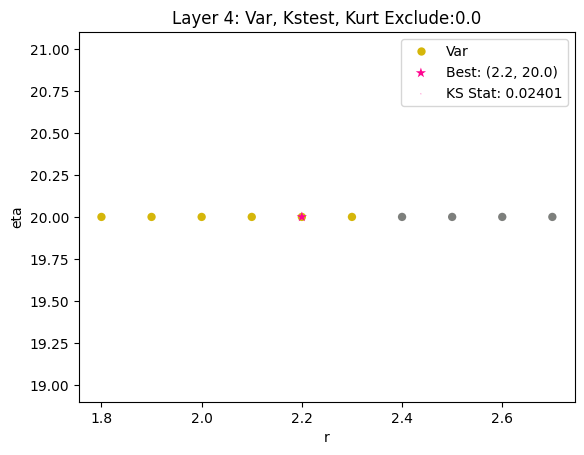

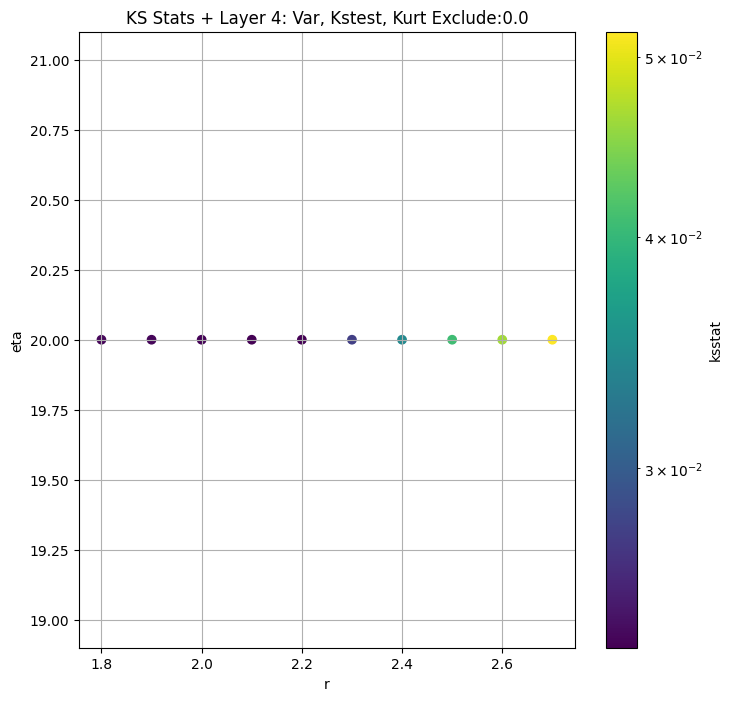

####
Layer  5


100%|██████████| 12760/12760 [00:45<00:00, 280.32it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.003294107681280245 89765.79


100%|██████████| 12760/12760 [00:44<00:00, 285.71it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.003294107681280245 88552.34


100%|██████████| 12760/12760 [00:46<00:00, 275.54it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.0029287396344158667 87637.57


100%|██████████| 12760/12760 [00:47<00:00, 267.84it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0029812669811902226 86815.734


100%|██████████| 12760/12760 [00:47<00:00, 269.76it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.002978644512222184 86059.97


100%|██████████| 12760/12760 [00:48<00:00, 265.32it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.0032842898816257404 84706.25


100%|██████████| 12760/12760 [00:44<00:00, 285.94it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.0036634520764210823 83501.93


100%|██████████| 12760/12760 [00:47<00:00, 270.17it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.004261892946003633 82409.05


100%|██████████| 12760/12760 [00:48<00:00, 261.89it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.004787243570643272 81401.945


100%|██████████| 12760/12760 [00:48<00:00, 265.49it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.005287038556008539 80466.125


100%|██████████| 12760/12760 [00:47<00:00, 266.38it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.006975059541262249 77970.71
Number of samples: 100000, Without approximation : 820632.0


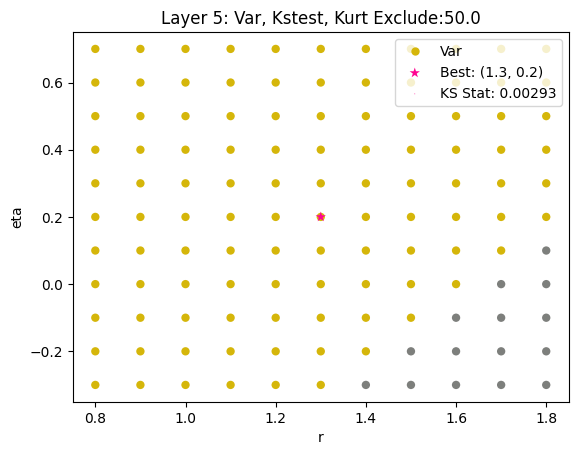

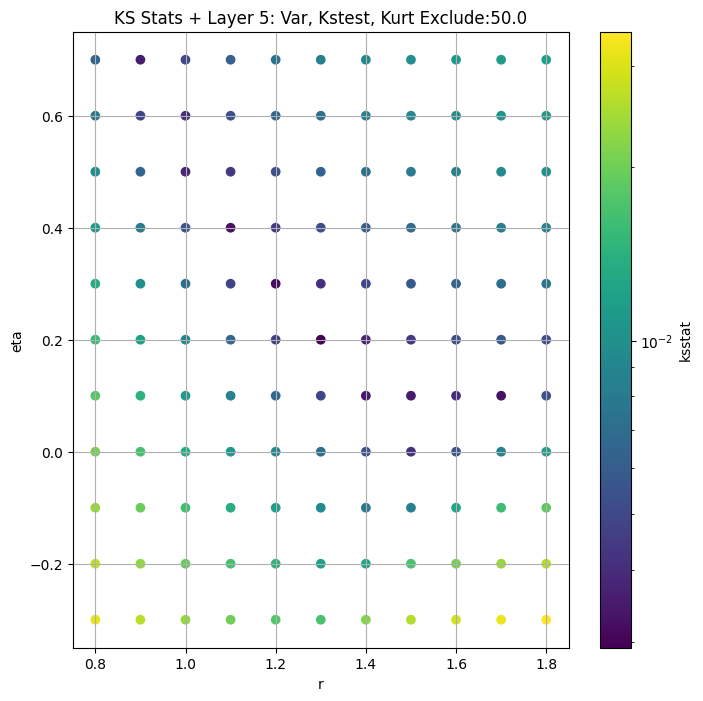

####
Layer  6


100%|██████████| 12760/12760 [00:48<00:00, 261.51it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.006956062096186821 27723.137


100%|██████████| 12760/12760 [00:47<00:00, 268.39it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.005765551744916275 27162.533


100%|██████████| 12760/12760 [00:47<00:00, 269.78it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.005266635638699391 26711.71


100%|██████████| 12760/12760 [00:47<00:00, 265.88it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.005497734228388951 26304.953


100%|██████████| 12760/12760 [00:53<00:00, 236.62it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.005277506460376405 25929.02


100%|██████████| 12760/12760 [00:49<00:00, 259.01it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.004749312909046288 25245.236


100%|██████████| 12760/12760 [00:46<00:00, 276.74it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.0048288156200168575 24632.086


100%|██████████| 12760/12760 [00:43<00:00, 292.21it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.004153923446790997 24072.082


100%|██████████| 12760/12760 [00:51<00:00, 247.04it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.0045955148380330095 23557.512


100%|██████████| 12760/12760 [00:48<00:00, 263.66it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.005121637931064571 23081.965


100%|██████████| 12760/12760 [00:51<00:00, 248.25it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.006643482920911135 21839.484
Number of samples: 100000, Without approximation : 3670424.0


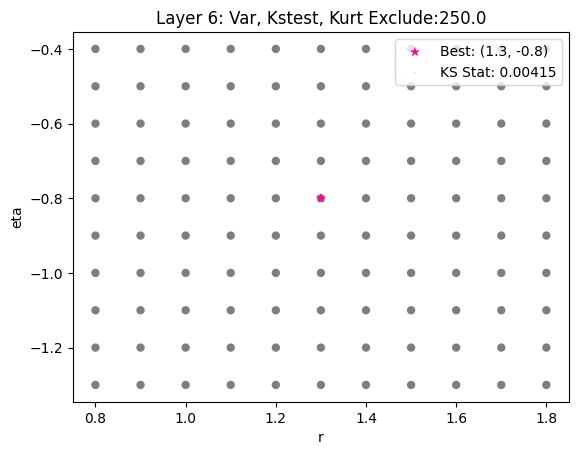

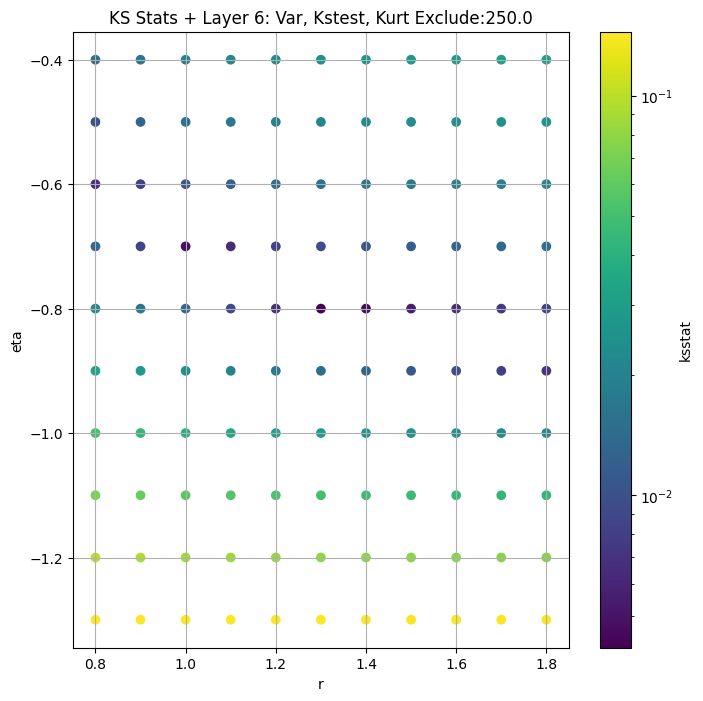

####
Layer  7


100%|██████████| 12760/12760 [00:48<00:00, 264.47it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.007101920411647311 5939.0757


100%|██████████| 12760/12760 [00:48<00:00, 264.91it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.007824861258271087 5809.5654


100%|██████████| 12760/12760 [00:47<00:00, 269.77it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.008148894343246726 5708.382


100%|██████████| 12760/12760 [00:47<00:00, 265.87it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.00706156335261976 5617.5156


100%|██████████| 12760/12760 [00:47<00:00, 270.81it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.006051919768469111 5533.83


100%|██████████| 12760/12760 [00:47<00:00, 266.85it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.004530310214850952 5381.8564


100%|██████████| 12760/12760 [00:48<00:00, 262.63it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.006353564894377273 5244.9736


100%|██████████| 12760/12760 [00:47<00:00, 270.41it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.00554276525521058 5119.252


100%|██████████| 12760/12760 [00:47<00:00, 270.39it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.005898311185895216 5002.6235


100%|██████████| 12760/12760 [00:48<00:00, 261.92it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.006336906190504551 4893.5005


100%|██████████| 12760/12760 [00:48<00:00, 264.72it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.007848049478268337 4600.954
Number of samples: 100000, Without approximation : 15384514.0


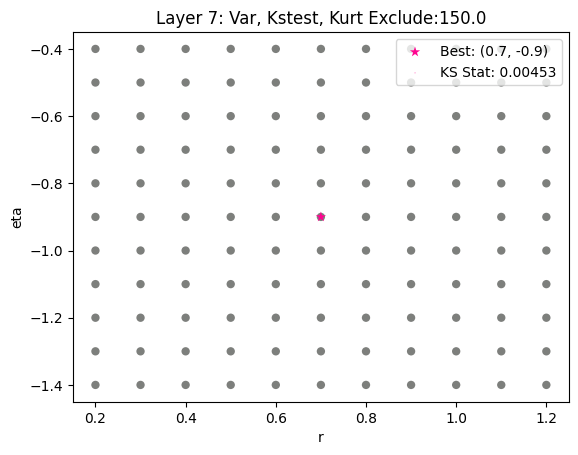

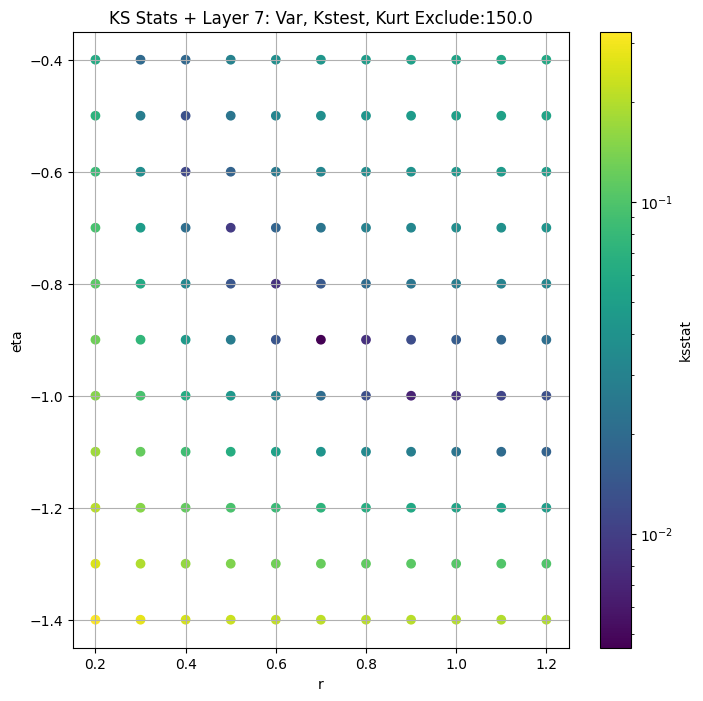

####
Layer  8


100%|██████████| 12760/12760 [00:48<00:00, 264.89it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.007280246970036486 762.6138


100%|██████████| 12760/12760 [00:49<00:00, 258.82it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.0055084868853293445 732.8818


100%|██████████| 12760/12760 [00:51<00:00, 249.18it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.004445369423384804 714.53


100%|██████████| 12760/12760 [00:48<00:00, 265.58it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.0038242654584052897 699.35345


100%|██████████| 12760/12760 [00:46<00:00, 274.50it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.004336023170535275 685.9309


100%|██████████| 12760/12760 [00:49<00:00, 257.02it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.004575438376334468 662.3878


100%|██████████| 12760/12760 [00:48<00:00, 263.43it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.005387958340814736 641.806


100%|██████████| 12760/12760 [00:48<00:00, 264.18it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.006030462539645648 623.29834


100%|██████████| 12760/12760 [00:49<00:00, 257.84it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.006170435754284775 606.4025


100%|██████████| 12760/12760 [00:48<00:00, 262.90it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.006824768005135928 590.79785


100%|██████████| 12760/12760 [00:49<00:00, 259.31it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.008628567196683989 549.84717
Number of samples: 100000, Without approximation : 62976002.0


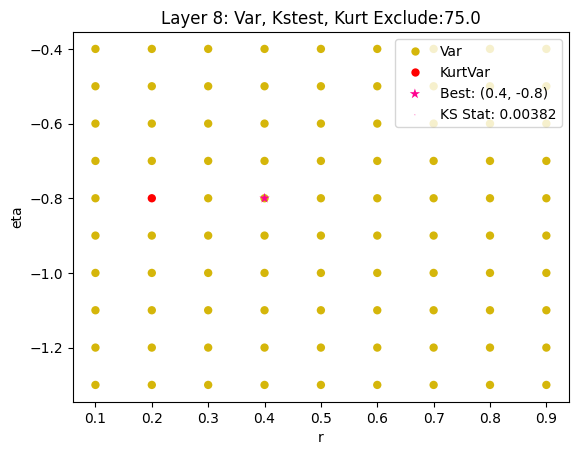

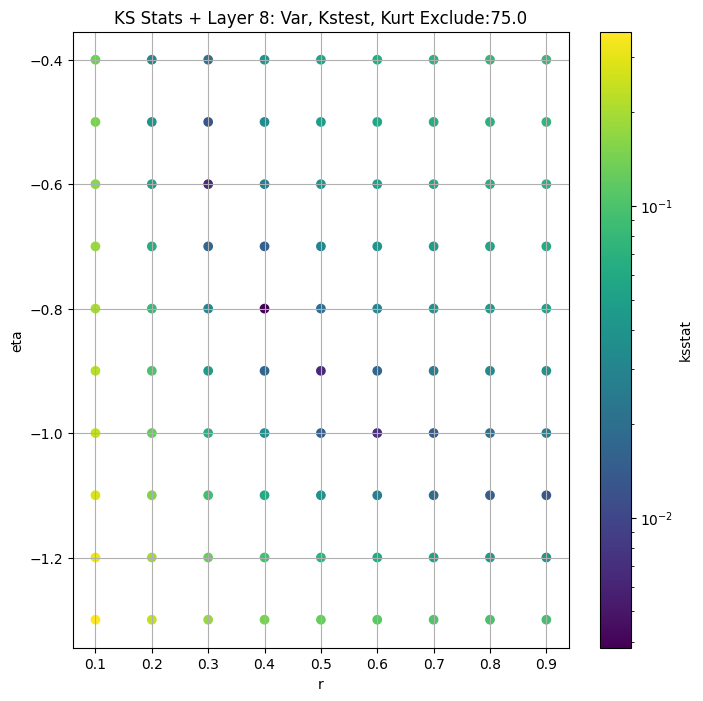

####
Layer  9


100%|██████████| 12760/12760 [00:51<00:00, 246.37it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.006181473768139822 72.97091


100%|██████████| 12760/12760 [00:52<00:00, 244.41it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.003493964630387203 68.01791


100%|██████████| 12760/12760 [00:51<00:00, 247.17it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.004540174022434451 65.31522


100%|██████████| 12760/12760 [00:49<00:00, 259.92it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.006772304315886768 63.20681


100%|██████████| 12760/12760 [00:47<00:00, 267.18it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.005798945308627401 61.415382


100%|██████████| 12760/12760 [00:49<00:00, 255.72it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.004624428027439884 58.408737


100%|██████████| 12760/12760 [00:49<00:00, 256.41it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.005821222169955606 55.894657


100%|██████████| 12760/12760 [00:52<00:00, 242.32it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.006887272449901283 53.71288


100%|██████████| 12760/12760 [00:49<00:00, 256.20it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.007451037187639509 51.777607


100%|██████████| 12760/12760 [00:53<00:00, 236.84it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.007956005422101842 50.035976


100%|██████████| 12760/12760 [00:50<00:00, 253.61it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.008470178988858601 45.66306
Number of samples: 100000, Without approximation : 254776200.0


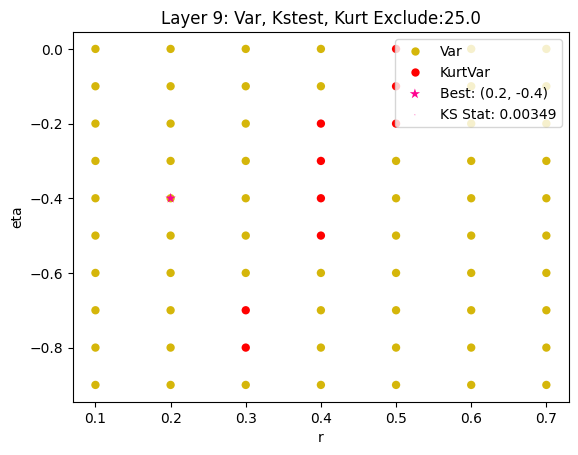

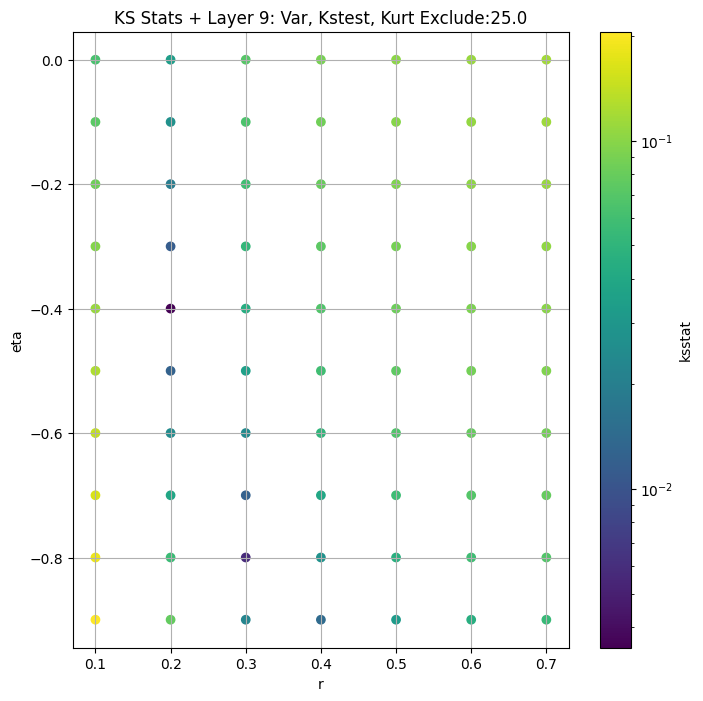

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,170305.00000,164909.47000,175804.86000,-0.464481,-0.540597,-0.383066,19544.0,0.021379,3.3,20.0,98104.240306,0.0,170305.00000,0.009706
4,269349.47000,260584.97000,278149.56000,-0.415785,-0.529190,-0.262445,177766.0,0.024011,2.2,20.0,96788.580679,0.0,269349.47000,0.003220
5,89765.79000,85311.62000,94332.43000,1.816636,1.392810,2.345721,820632.0,0.002929,1.3,0.2,75896.227113,50.0,87637.57000,0.001499
6,27723.13700,25801.26000,29725.77000,5.616802,4.711250,6.687731,3670424.0,0.004154,1.3,-0.8,44293.576994,250.0,24072.08200,0.000709
7,5939.07570,5490.06700,6403.12160,7.063244,6.073430,8.459994,15384514.0,0.004530,0.7,-0.9,5144.353461,150.0,5381.85640,0.000346
8,762.61380,692.95807,839.26680,11.767686,8.738594,18.807537,62976002.0,0.003824,0.4,-0.8,77.579113,75.0,699.35345,0.000171
9,72.97091,64.01033,83.24985,23.847502,14.821177,42.472622,254776200.0,0.003494,0.2,-0.4,0.003142,25.0,68.01791,0.000085


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


100%|██████████| 9/9 [00:00<00:00, 806.89it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.027669609635848413, var: 160110.40625


100%|██████████| 9/9 [00:00<00:00, 926.21it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.026320765228824983, var: 162222.5625


100%|██████████| 9/9 [00:00<00:00, 1197.46it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.024882507661585618, var: 164473.203125


100%|██████████| 9/9 [00:00<00:00, 843.66it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.023321938303791978, var: 167002.609375


100%|██████████| 9/9 [00:00<00:00, 820.57it/s]

Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.02137939222871399, var: 170305.0
Number of samples: 19544, Without approximation : 19544.0


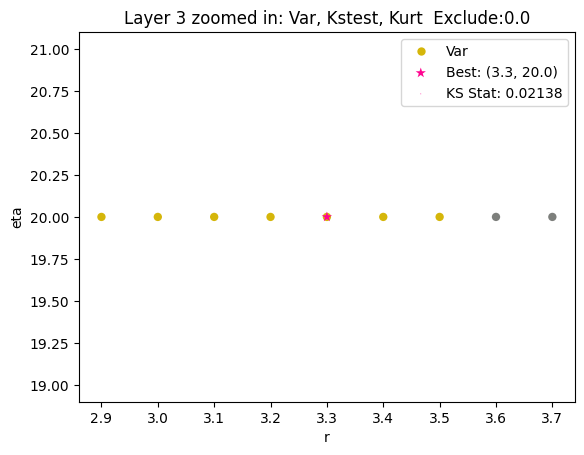

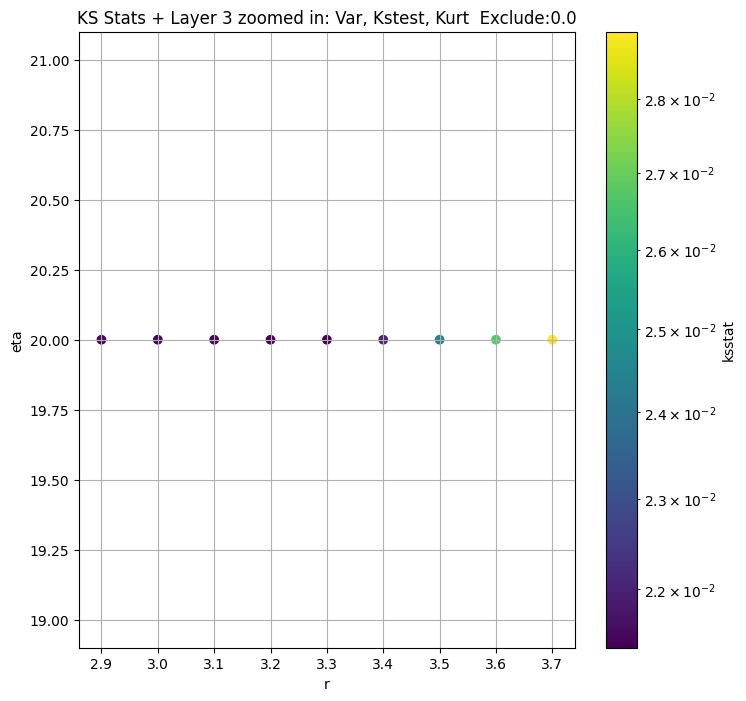

Layer 4


100%|██████████| 36/36 [00:00<00:00, 165.95it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.026225315315881903, var: 264230.1875


100%|██████████| 36/36 [00:00<00:00, 262.79it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.025807807751706935, var: 265186.59375


100%|██████████| 36/36 [00:00<00:00, 264.31it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.02534365744232711, var: 266254.625


100%|██████████| 36/36 [00:00<00:00, 246.37it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.024804264230758155, var: 267502.15625


100%|██████████| 36/36 [00:00<00:00, 265.70it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.02401096317428736, var: 269349.46875
Number of samples: 100000, Without approximation : 177766.0


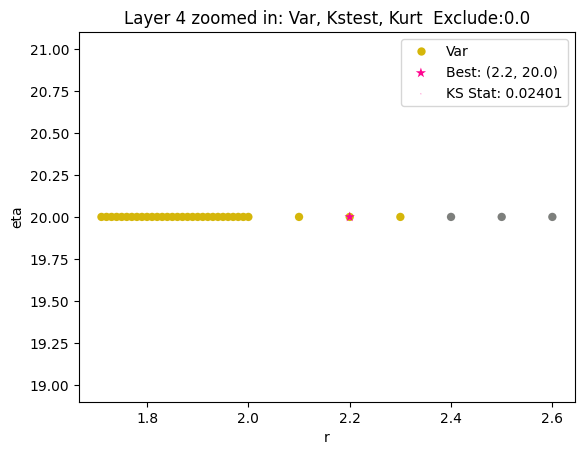

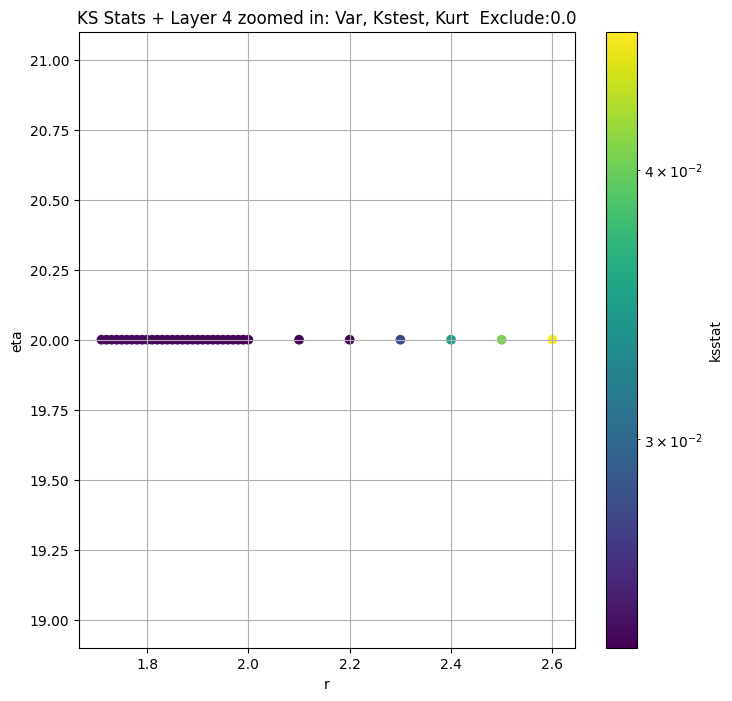

Layer 5


100%|██████████| 1233/1233 [00:05<00:00, 235.86it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.0030982431101056473, var: 84706.25


100%|██████████| 1233/1233 [00:04<00:00, 275.07it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.0029870133382923214, var: 85362.4140625


100%|██████████| 1233/1233 [00:04<00:00, 254.35it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.0029171241633815237, var: 86059.96875


100%|██████████| 1233/1233 [00:04<00:00, 262.73it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.002831574196401787, var: 86815.734375


100%|██████████| 1233/1233 [00:04<00:00, 264.35it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.0029287396344158667, var: 87637.5703125


100%|██████████| 1233/1233 [00:04<00:00, 271.87it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0030402995856273485, var: 88552.34375


100%|██████████| 1233/1233 [00:04<00:00, 268.78it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.0030402995856273485, var: 89765.7890625
Number of samples: 100000, Without approximation : 820632.0


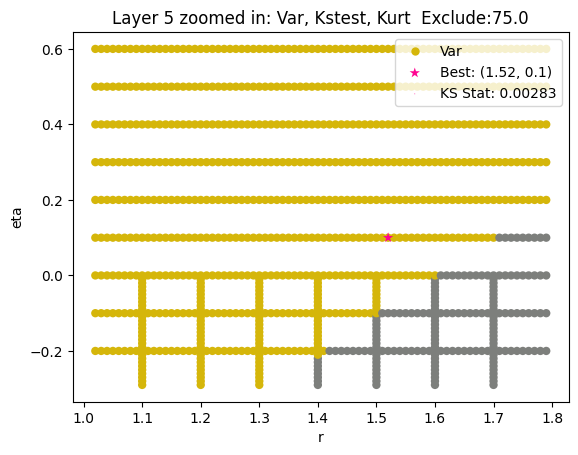

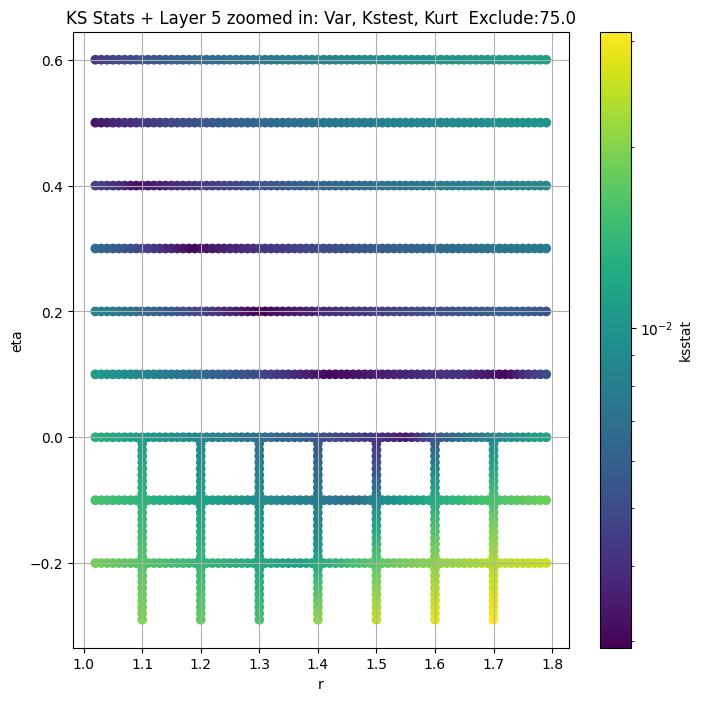

Layer 6


100%|██████████| 1701/1701 [00:06<00:00, 262.66it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.0049968166395089955, var: 23081.96484375


100%|██████████| 1701/1701 [00:06<00:00, 270.76it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.004742539693273096, var: 23315.27734375


100%|██████████| 1701/1701 [00:06<00:00, 274.16it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.004496436293315587, var: 23557.51171875


100%|██████████| 1701/1701 [00:06<00:00, 268.16it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.004250026746565716, var: 23809.3671875


100%|██████████| 1701/1701 [00:06<00:00, 265.83it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.004020727353340145, var: 24072.08203125


100%|██████████| 1701/1701 [00:06<00:00, 281.45it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.003854267368488151, var: 24346.26953125


100%|██████████| 1701/1701 [00:06<00:00, 267.56it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.0038445721726027976, var: 24632.0859375


100%|██████████| 1701/1701 [00:06<00:00, 281.88it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.0039960475345699464, var: 24931.1171875


100%|██████████| 1701/1701 [00:06<00:00, 274.44it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.004261843572176738, var: 25245.236328125
Number of samples: 100000, Without approximation : 3670424.0


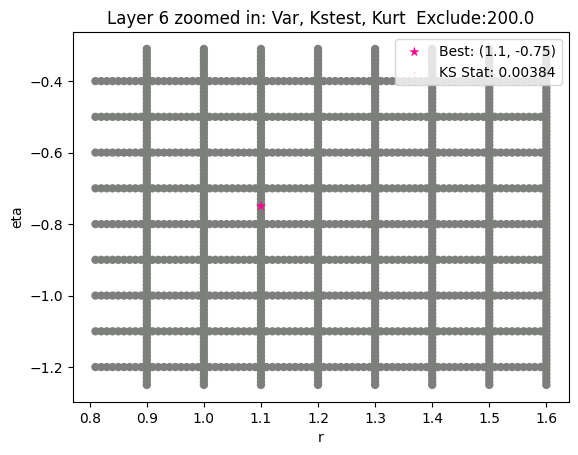

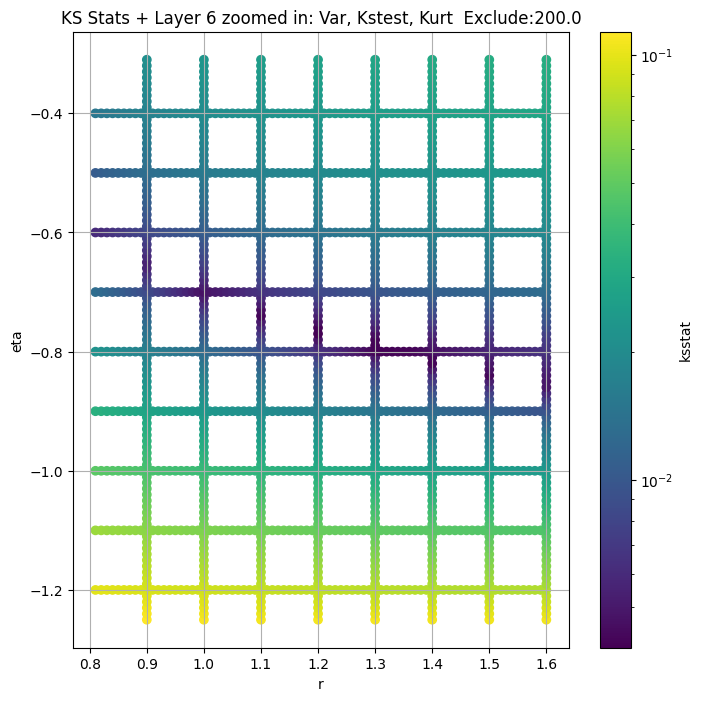

Layer 7


100%|██████████| 1900/1900 [00:06<00:00, 273.91it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.005248236210511797, var: 5119.251953125


100%|██████████| 1900/1900 [00:06<00:00, 276.08it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.005007382217421141, var: 5180.8779296875


100%|██████████| 1900/1900 [00:06<00:00, 274.87it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.004722346897830909, var: 5244.9736328125


100%|██████████| 1900/1900 [00:08<00:00, 221.44it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.004483789146872197, var: 5311.80615234375


100%|██████████| 1900/1900 [00:07<00:00, 246.62it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.004530310214850952, var: 5381.8564453125


100%|██████████| 1900/1900 [00:07<00:00, 267.90it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.004668053856230148, var: 5455.62841796875


100%|██████████| 1900/1900 [00:06<00:00, 273.22it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.005061590489003676, var: 5533.830078125


100%|██████████| 1900/1900 [00:06<00:00, 278.39it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.004506124307351894, var: 5617.515625


100%|██████████| 1900/1900 [00:06<00:00, 276.28it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.005102929312563564, var: 5708.3818359375
Number of samples: 100000, Without approximation : 15384514.0


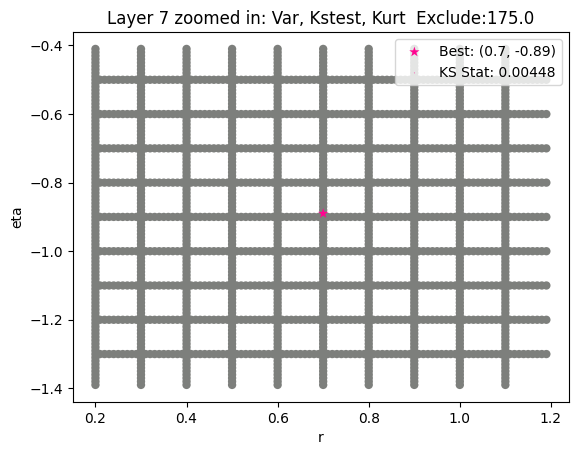

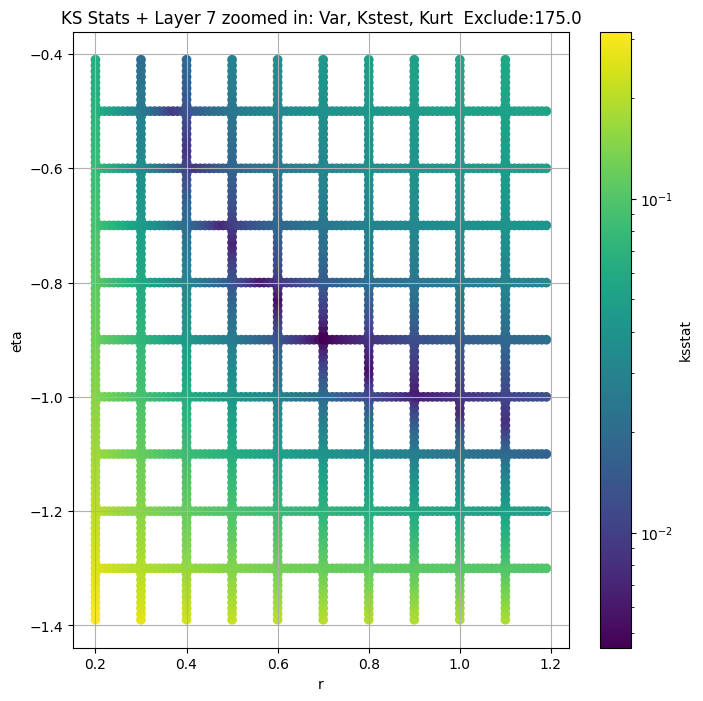

Layer 8


100%|██████████| 1512/1512 [00:05<00:00, 261.00it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.004894243919149166, var: 651.7974853515625


100%|██████████| 1512/1512 [00:06<00:00, 245.86it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.004536077033868935, var: 662.3878173828125


100%|██████████| 1512/1512 [00:05<00:00, 267.59it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.0041585282158440595, var: 673.703857421875


100%|██████████| 1512/1512 [00:05<00:00, 279.89it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.0037356738333563545, var: 685.930908203125


100%|██████████| 1512/1512 [00:05<00:00, 284.86it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.003414094824867653, var: 699.3534545898438


100%|██████████| 1512/1512 [00:05<00:00, 267.45it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.00330005017040369, var: 714.530029296875


100%|██████████| 1512/1512 [00:05<00:00, 278.65it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.002816803306889437, var: 732.8817749023438


100%|██████████| 1512/1512 [00:05<00:00, 275.27it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.003263948192618271, var: 762.61376953125
Number of samples: 100000, Without approximation : 62976002.0


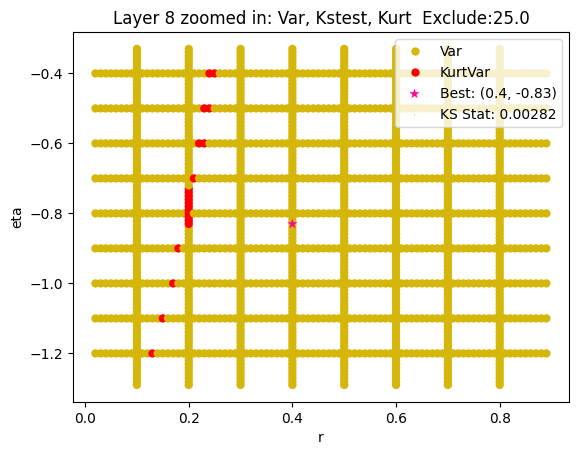

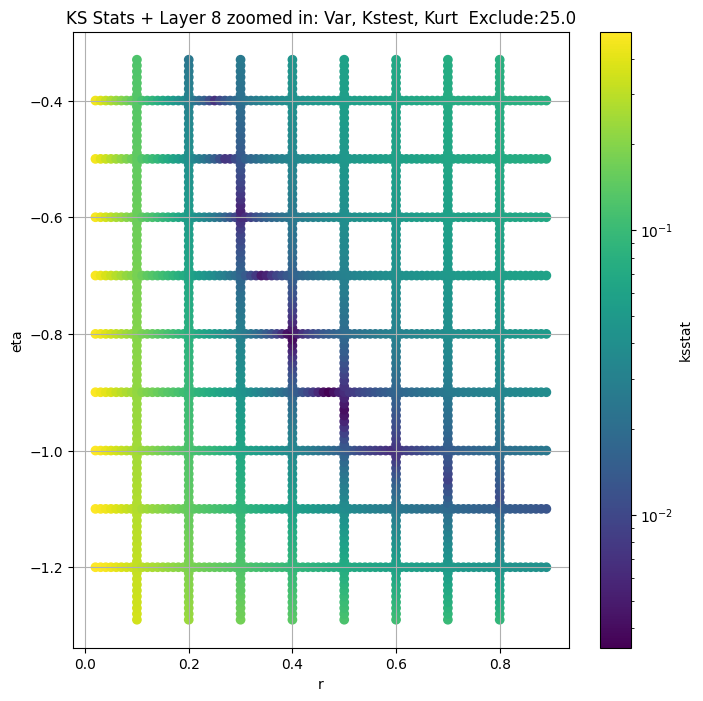

Layer 9


100%|██████████| 1188/1188 [00:04<00:00, 268.32it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.003802471384727363, var: 59.83527755737305


100%|██████████| 1188/1188 [00:04<00:00, 265.00it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.0034705488648871796, var: 61.415382385253906


100%|██████████| 1188/1188 [00:04<00:00, 276.88it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.0030240661858493834, var: 63.206809997558594


100%|██████████| 1188/1188 [00:04<00:00, 275.70it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.0030026235039450344, var: 65.31522369384766


100%|██████████| 1188/1188 [00:04<00:00, 254.93it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.0023778412284107264, var: 68.01790618896484


100%|██████████| 1188/1188 [00:05<00:00, 231.00it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.001953726503903075, var: 72.97090911865234
Number of samples: 100000, Without approximation : 254776200.0


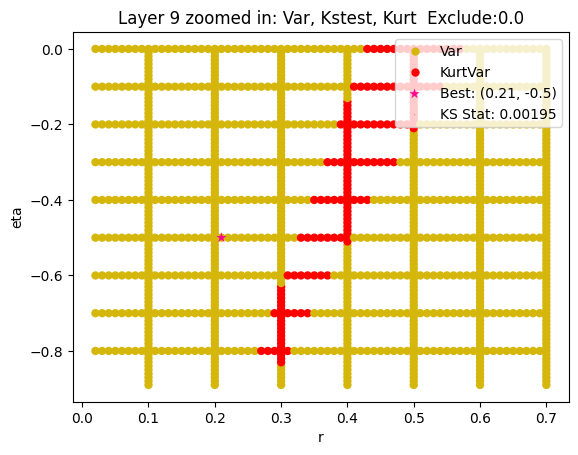

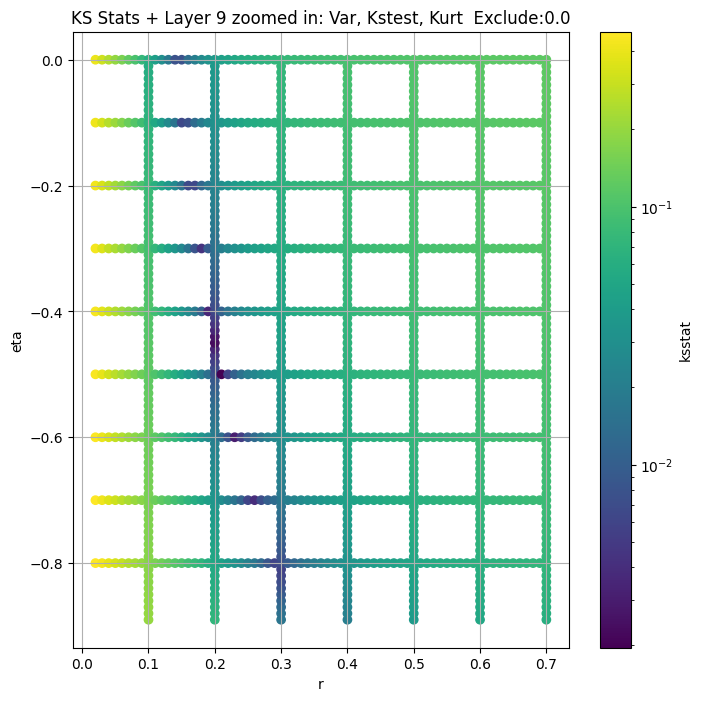

Cannot compute pval with ksstat : 1.0, n : 0.0


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-1
3,170305.00000,164909.47000,175804.86000,-0.464481,-0.540597,-0.383066,19544.0,0.021379,3.3,20.0,98104.240306,0.0,170305.000000,0.009706,0.021379,3.30,20.00,98104.240306,0.0,4122
4,269349.47000,260584.97000,278149.56000,-0.415785,-0.529190,-0.262445,177766.0,0.024011,2.2,20.0,96788.580679,0.0,269349.470000,0.003220,0.024011,2.20,20.00,96788.580679,0.0,3123
5,89765.79000,85311.62000,94332.43000,1.816636,1.392810,2.345721,820632.0,0.002929,1.3,0.2,75896.227113,50.0,86815.734375,0.001499,0.002832,1.52,0.10,92684.255325,75.0,230802
6,27723.13700,25801.26000,29725.77000,5.616802,4.711250,6.687731,3670424.0,0.004154,1.3,-0.8,44293.576994,250.0,24632.085938,0.000709,0.003845,1.10,-0.75,36644.981469,200.0,129037
7,5939.07570,5490.06700,6403.12160,7.063244,6.073430,8.459994,15384514.0,0.004530,0.7,-0.9,5144.353461,150.0,5311.806152,0.000346,0.004484,0.70,-0.89,4975.299048,175.0,90142
8,762.61380,692.95807,839.26680,11.767686,8.738594,18.807537,62976002.0,0.003824,0.4,-0.8,77.579113,75.0,732.881775,0.000171,0.002817,0.40,-0.83,88.266105,25.0,246000
9,72.97091,64.01033,83.24985,23.847502,14.821177,42.472622,254776200.0,0.003494,0.2,-0.4,0.003142,25.0,72.970909,0.000085,0.001954,0.21,-0.50,0.009796,0.0,497609


In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

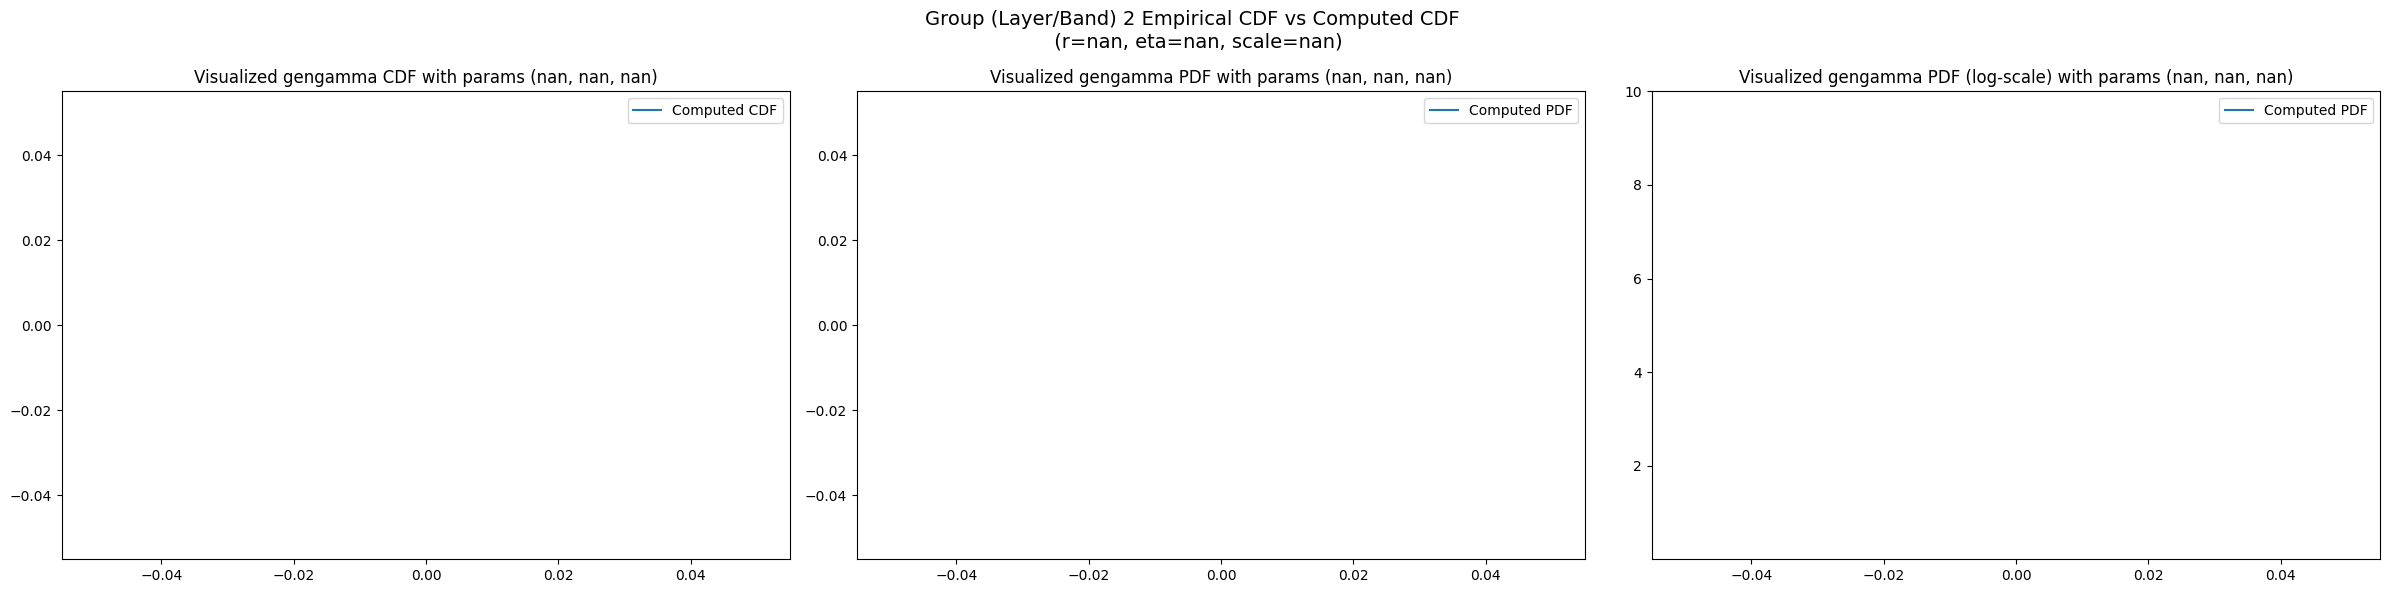

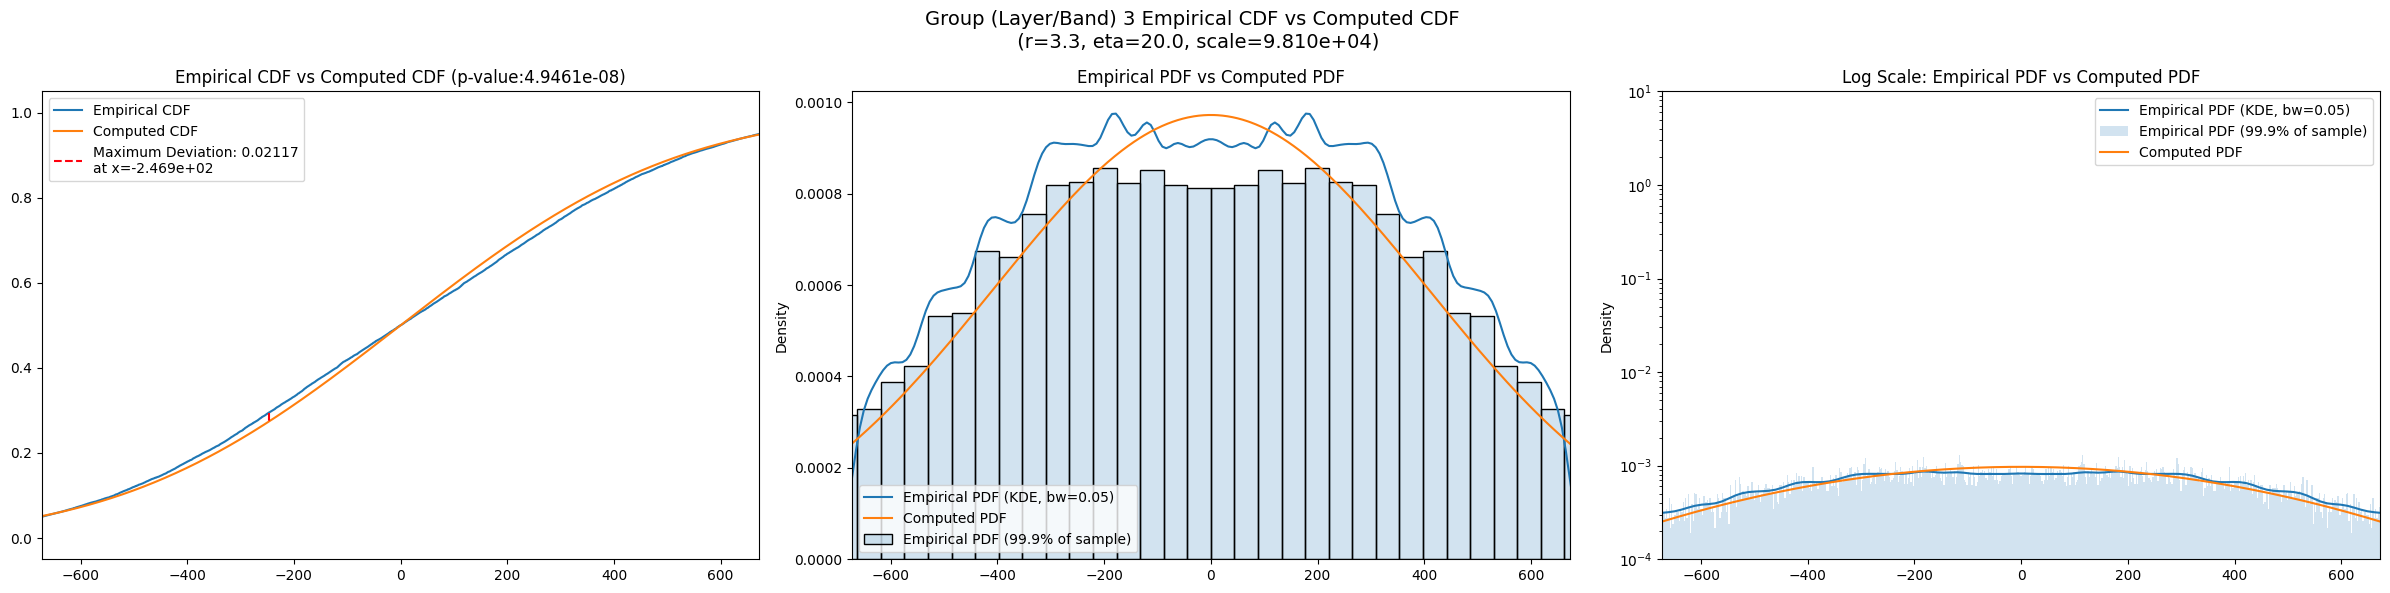

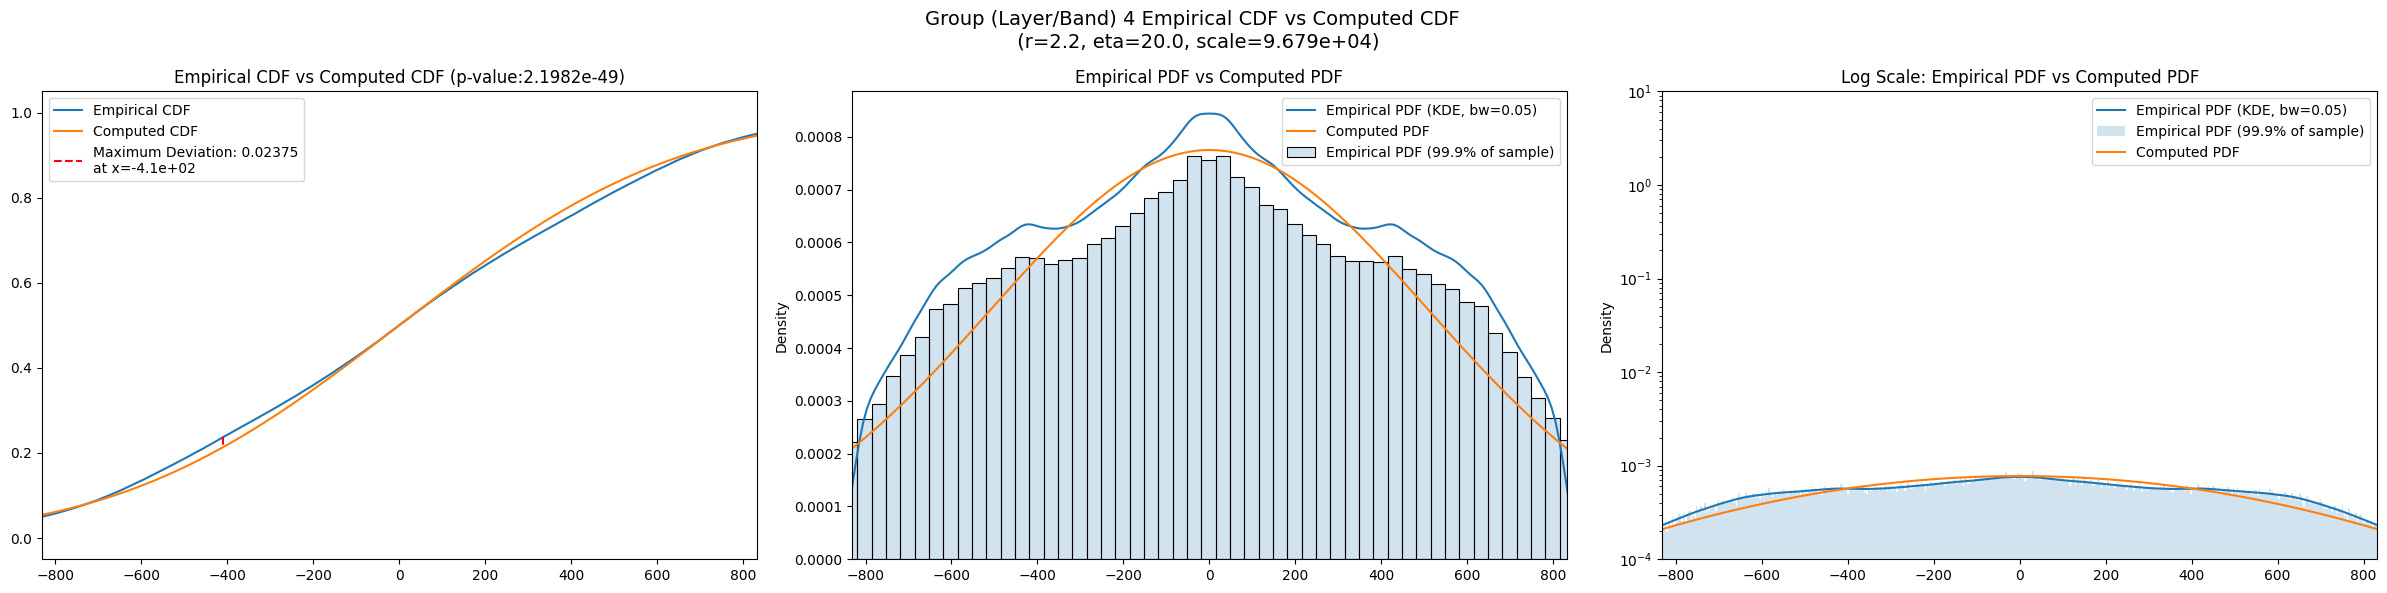

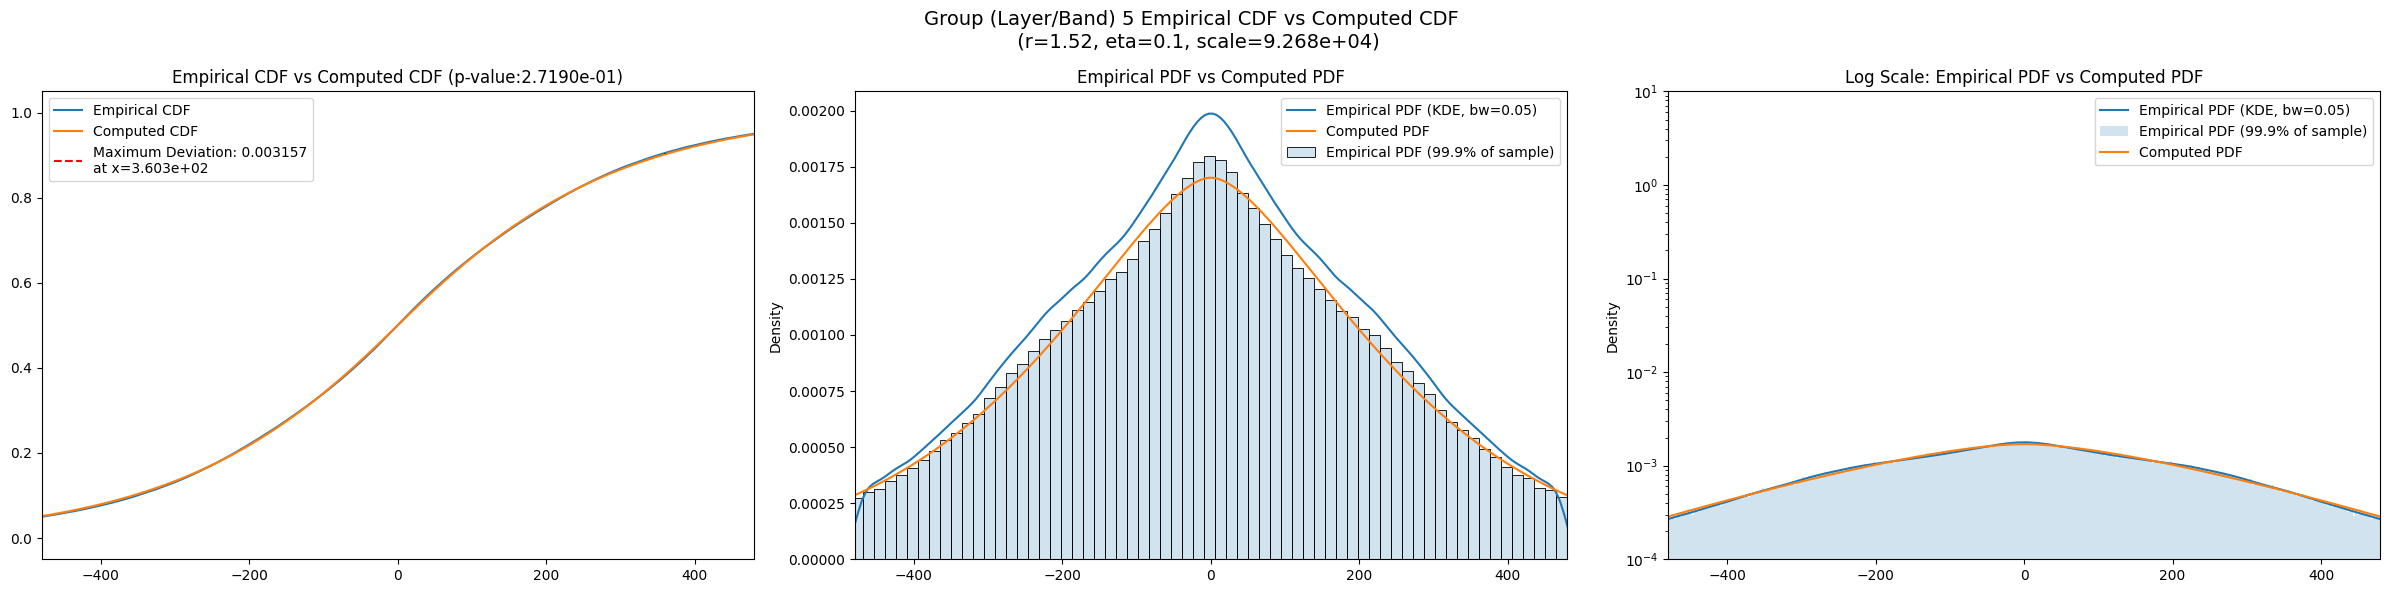

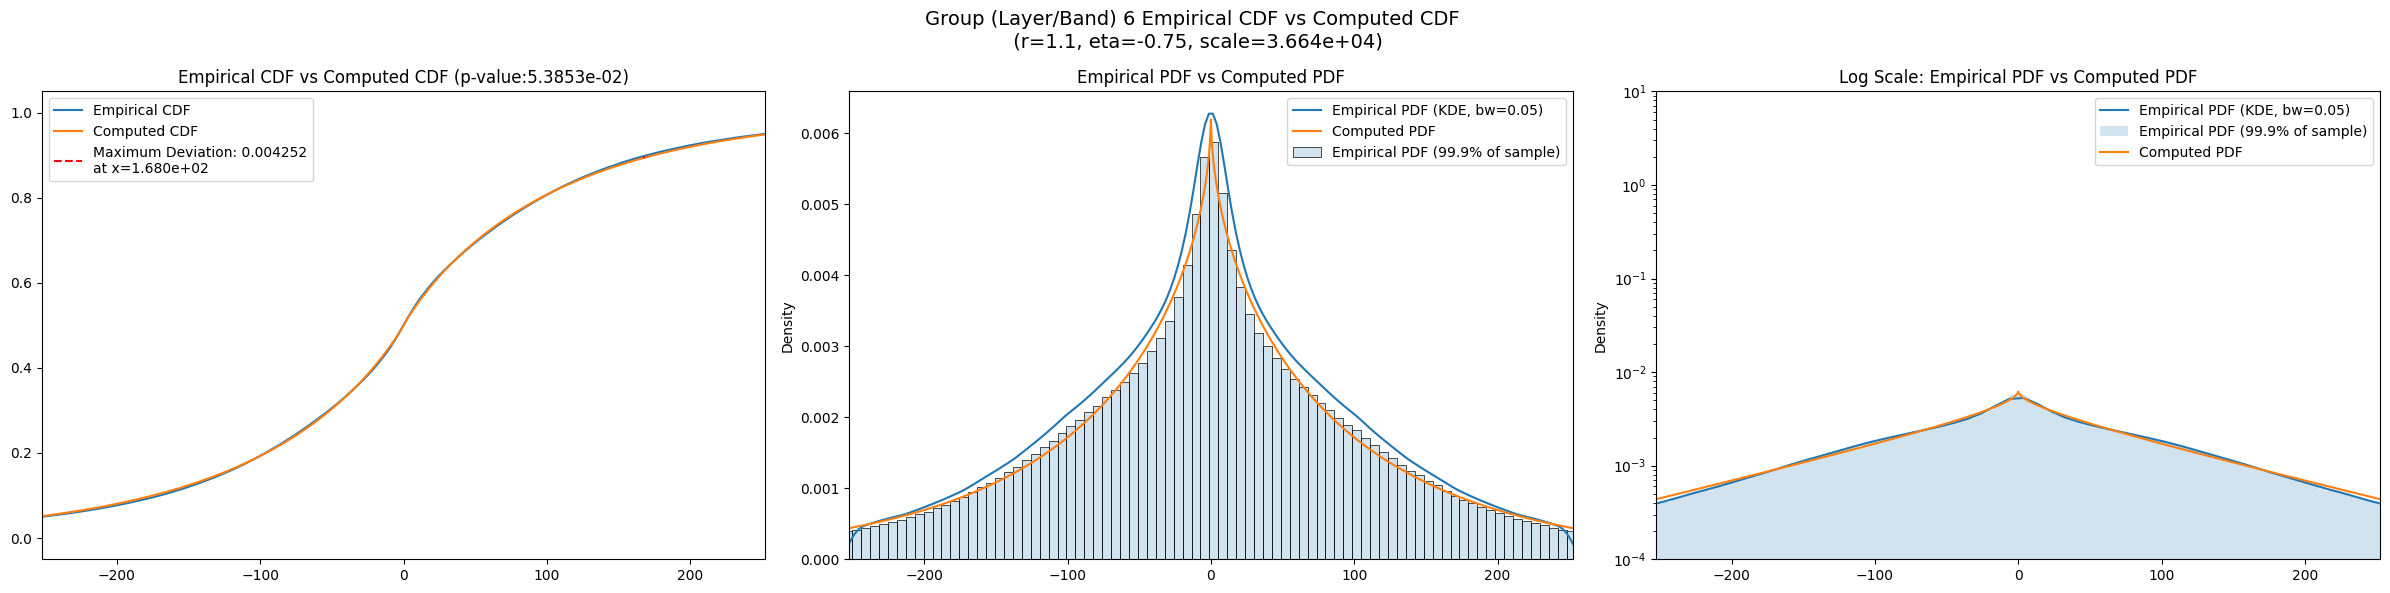

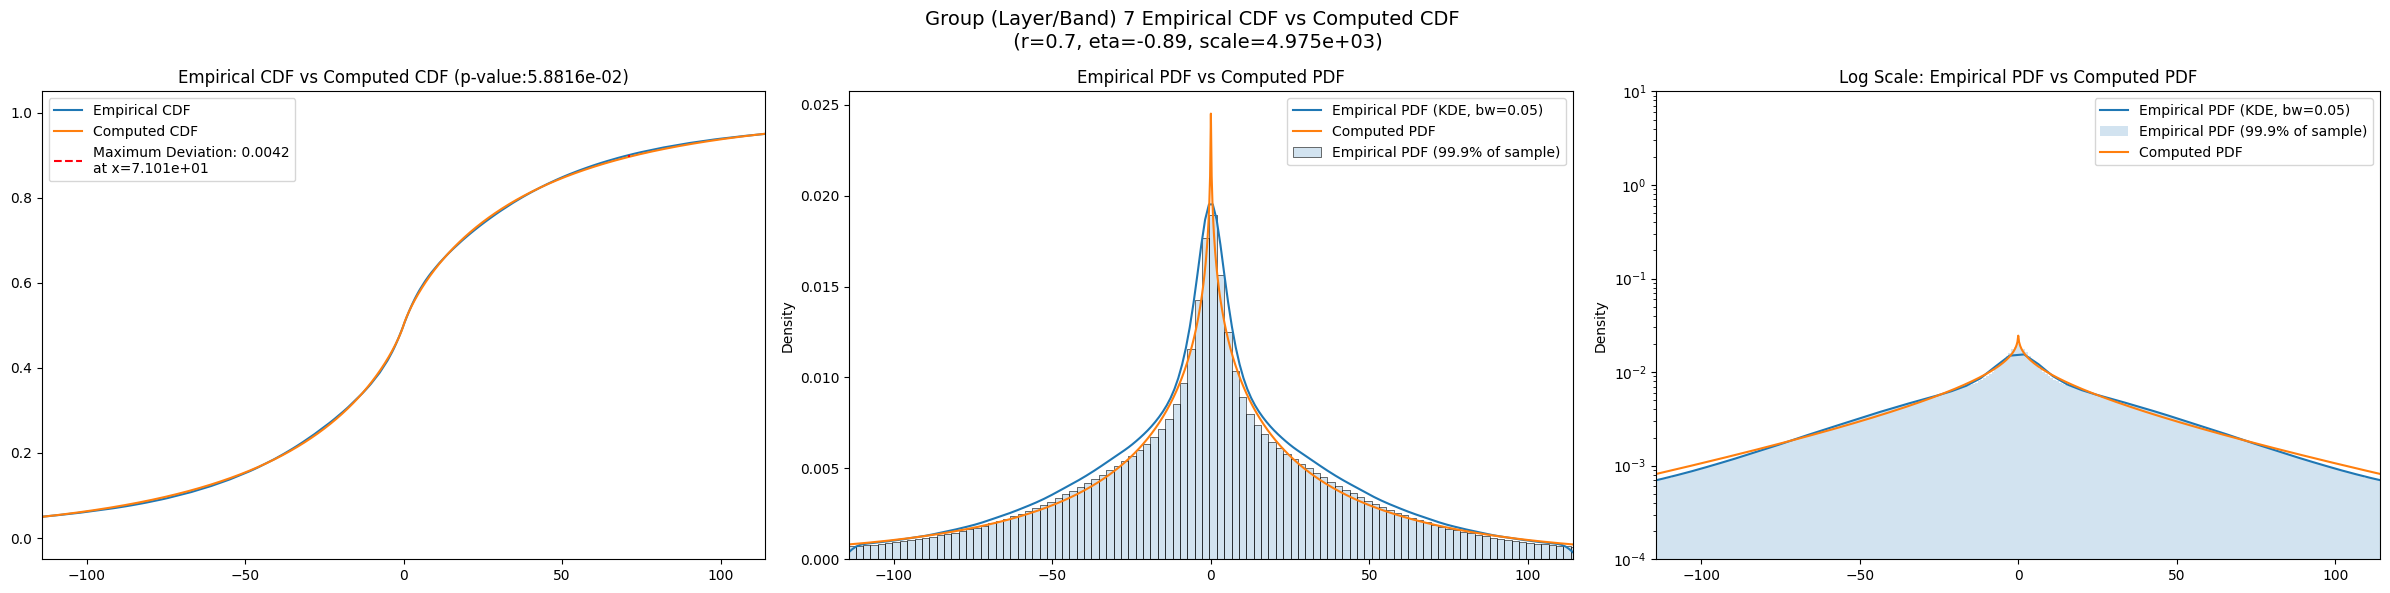

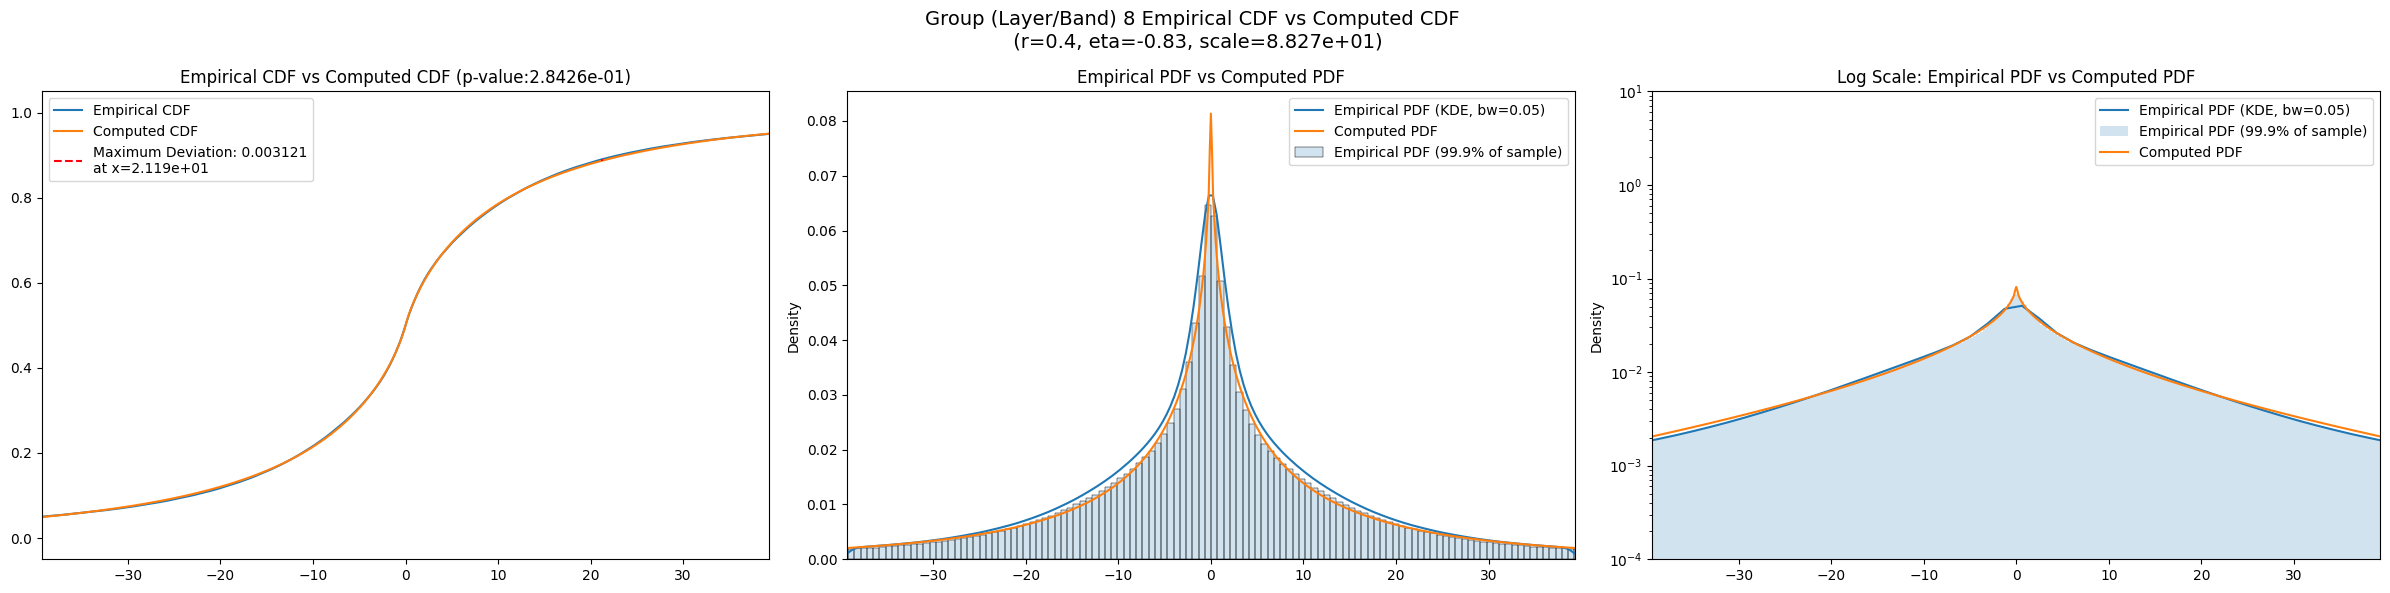

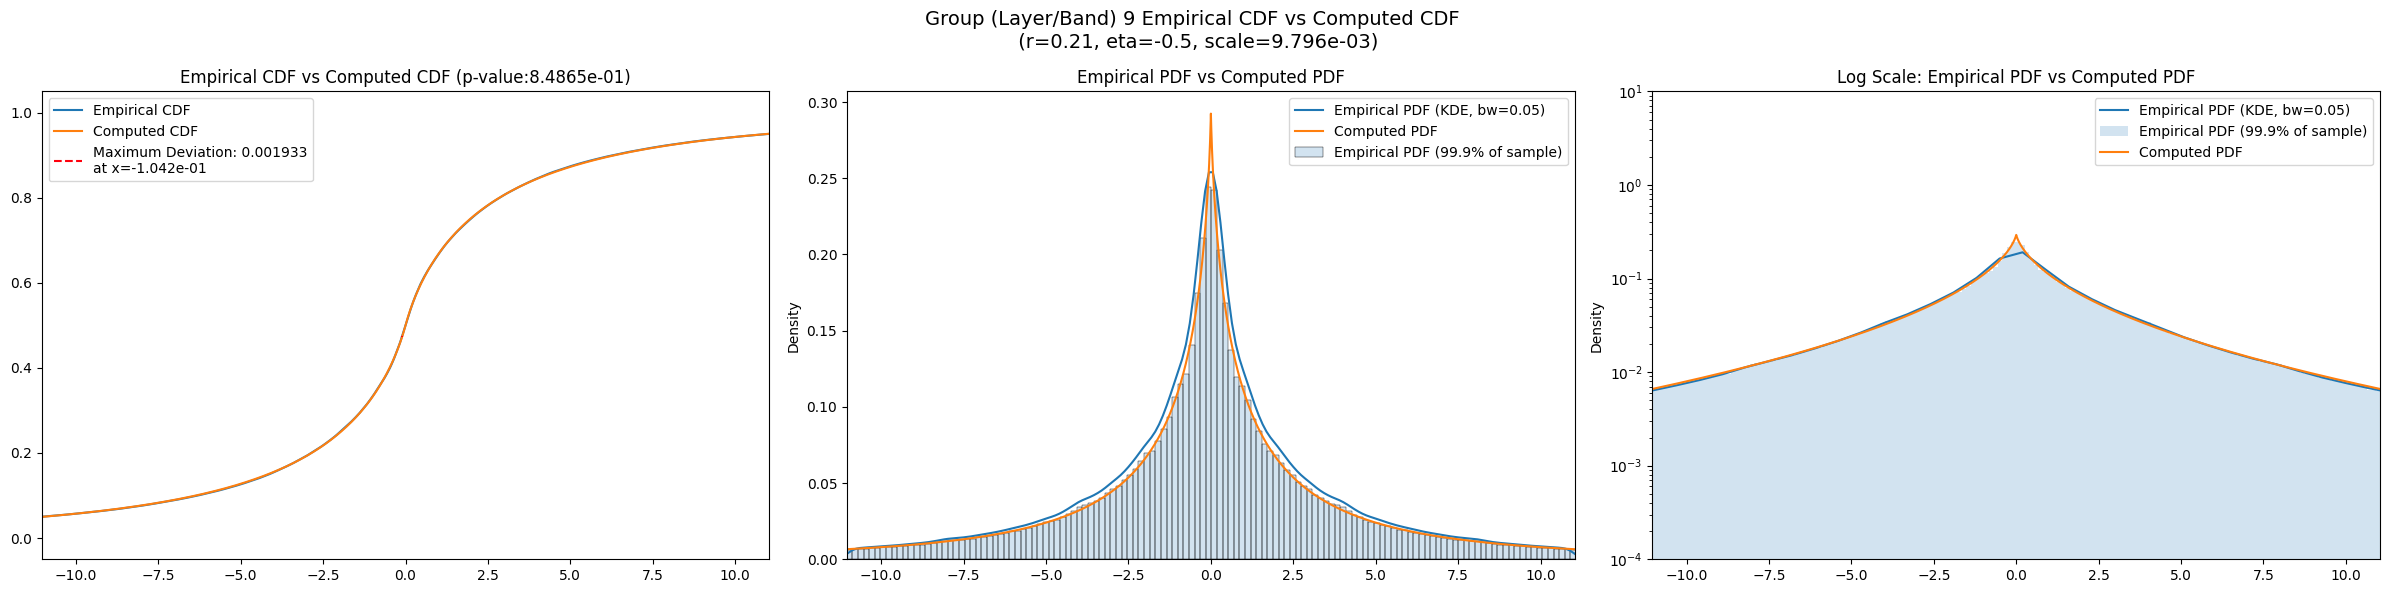

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [18]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [21]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,170305.00000,164909.47000,175804.86000,-0.464481,-0.540597,-0.383066,19544.0,0.021379,3.3,20.0,...,433.5290,0.012450,4.634060e-03,379.0590,0.040592,2.031160e-28,309.68900,0.041724,5.308450e-30,3.426982e-08
4,269349.47000,260584.97000,278149.56000,-0.415785,-0.529190,-0.262445,177766.0,0.024011,2.2,20.0,...,542.6020,0.012403,3.513010e-24,466.3760,0.036658,5.444050e-208,386.69300,0.040586,7.218110e-255,1.836076e-89
5,89765.79000,85311.62000,94332.43000,1.816636,1.392810,2.345721,820632.0,0.002929,1.3,0.2,...,268.1650,0.014941,1.449820e-159,233.9960,0.014092,5.538000e-142,192.57900,0.017854,1.200100e-227,3.847422e-06
6,27723.13700,25801.26000,29725.77000,5.616802,4.711250,6.687731,3670424.0,0.004154,1.3,-0.8,...,118.2890,0.034389,0.000000e+00,101.1830,0.009509,1.052680e-288,83.88910,0.015877,0.000000e+00,1.505241e-47
7,5939.07570,5490.06700,6403.12160,7.063244,6.073430,8.459994,15384514.0,0.004530,0.7,-0.9,...,45.5471,0.048245,0.000000e+00,39.0462,0.023592,0.000000e+00,31.24510,0.027386,0.000000e+00,4.453877e-269
8,762.61380,692.95807,839.26680,11.767686,8.738594,18.807537,62976002.0,0.003824,0.4,-0.8,...,14.0442,0.056573,0.000000e+00,12.1815,0.031154,0.000000e+00,9.52024,0.032610,0.000000e+00,0.000000e+00
9,72.97091,64.01033,83.24985,23.847502,14.821177,42.472622,254776200.0,0.003494,0.2,-0.4,...,3.7067,0.061274,0.000000e+00,3.2468,0.034819,0.000000e+00,2.51904,0.035631,0.000000e+00,0.000000e+00


## Results

In [22]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [23]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,1.000000,NaN,1.000000,NaN,NaN,NaN
3,0.021379,0.009706,0.021379,0.012450,0.040592,0.041724
4,0.024011,0.003220,0.024011,0.012403,0.036658,0.040586
5,0.002929,0.001499,0.002832,0.014941,0.014092,0.017854
6,0.004154,0.000709,0.003845,0.034389,0.009509,0.015877
7,0.004530,0.000346,0.004484,0.048245,0.023592,0.027386
8,0.003824,0.000171,0.002817,0.056573,0.031154,0.032610
9,0.003494,0.000085,0.001954,0.061274,0.034819,0.035631


In [24]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,NaN,1.000000,NaN,NaN,NaN,NaN
3,170305.000000,0.021379,3.30,20.00,98104.240306,0.0
4,269349.470000,0.024011,2.20,20.00,96788.580679,0.0
5,86815.734375,0.002832,1.52,0.10,92684.255325,75.0
6,24632.085938,0.003845,1.10,-0.75,36644.981469,200.0
7,5311.806152,0.004484,0.70,-0.89,4975.299048,175.0
8,732.881775,0.002817,0.40,-0.83,88.266105,25.0
9,72.970909,0.001954,0.21,-0.50,0.009796,0.0
